In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *
from datetime import datetime
import sys
import statsmodels
import patsy
import pmdarima
import statsmodels.formula.api as smf

In [7]:
path = Path(os.getcwd())

In [3]:
base_dir = path.parent.parent

In [4]:
data_in = os.path.join(str(base_dir) , "da_data_repo/case-shiller-la/clean/")
data_out = os.path.join(str(base_dir) , "da_data_repo/ch18-case-shiller-la/")
output = os.path.join(data_out,'output')
func = os.path.join(str(base_dir) ,   "da_case_studies/ch00-tech-prep/")

In [5]:
sys.path.append(func)
from py_helper_functions import *

In [8]:
#rds_path = os.path.join(data_in,"houseprices-data-1990-2018.rds")
#result = pyreadr.read_r(rds_path)

In [9]:
csv_path = os.path.join(data_in,"houseprices-data-1990-2018.csv")
data = pd.read_csv(csv_path)

In [10]:
data.head()

,date,CANA,CANAN,CAUR,CAURN,LXXRNSA,LXXRSA,ps,pn,us,un,emps,empn
0,1990 jan.,12495.2,12329.0,5.2,5.7,100.225510,100.471193,100.471193,100.225510,5.2,5.7,12495.2,12329.0
1,1990 febr.,12500.7,12399.1,5.2,5.6,100.151430,100.761572,100.761572,100.151430,5.2,5.6,12500.7,12399.1
2,1990 márc.,12503.6,12476.7,5.2,5.4,100.017670,100.992838,100.992838,100.017670,5.2,5.4,12503.6,12476.7
3,1990 ápr.,12536.4,12502.9,5.3,5.4,99.986753,100.990410,100.990410,99.986753,5.3,5.4,12536.4,12502.9
4,1990 máj.,12553.2,12566.3,5.4,5.2,99.791606,100.394583,100.394583,99.791606,5.4,5.2,12553.2,12566.3


### Format dates

In [11]:
data[['year', 'month']] = data['date'].str.split(' ', n=1, expand=True)
month_dict = {'jan.':'01',
              'febr.':'02',
              'márc.':'03',
              'ápr.':'04',
              'máj.':'05',
              'jún.':'06',
              'júl.':'07',
              'aug.':'08',
              'szept.':'09',
              'okt.':'10',
              'nov.':'11',
              'dec.':'12'}
data['month1']='-' + data['month'].map(month_dict)
data['date1']=data['year']+data['month1']
data['date']=pd.to_datetime(data['date1'])
data = data.drop(['year','month','month1','date1'],axis=1)

In [12]:
data.dtypes

date       datetime64[ns]
CANA              float64
CANAN             float64
CAUR              float64
CAURN             float64
LXXRNSA           float64
LXXRSA            float64
ps                float64
pn                float64
us                float64
un                float64
emps              float64
empn              float64
dtype: object

In [13]:
data = data[(data['date'] >= '2000-01-01') & (data['date'] < '2018-01-01')]

In [14]:
data = data.sort_values('date')

In [15]:
data.head()

,date,CANA,CANAN,CAUR,CAURN,LXXRNSA,LXXRSA,ps,pn,us,un,emps,empn
120,2000-01-01,14346.8,14132.7,5.0,5.4,100.00000,101.031209,101.031209,100.00000,5.0,5.4,14346.8,14132.7
121,2000-02-01,14390.6,14270.0,5.0,5.4,100.61896,102.043406,102.043406,100.61896,5.0,5.4,14390.6,14270.0
122,2000-03-01,14431.7,14421.3,5.0,5.4,102.12780,103.224699,103.224699,102.12780,5.0,5.4,14431.7,14421.3
123,2000-04-01,14482.4,14451.0,5.1,4.8,103.70410,104.159399,104.159399,103.70410,5.1,4.8,14482.4,14451.0
124,2000-05-01,14550.6,14590.2,5.1,4.8,104.98908,104.924698,104.924698,104.98908,5.1,4.8,14550.6,14590.2


In [16]:
data = data.assign(p=data['pn'],u=data['us'],emp=data['emps'])

In [17]:
data =  data.assign(
        dp = data['p'].diff(),
        p_lag = data['p'].shift(),
        lnp = np.log(data['p']))
data =  data.assign(
        dlnp = data['lnp'].diff(),
        lnp_lag = data['lnp'].shift())
data =  data.assign(
        dlnp_lag = data['dlnp'].shift(),
        du = data['u'].diff(),
        lnemp = np.log(data['emp']))

data['dlnemp'] = data['lnemp'].diff()

In [18]:
data = data.reset_index(drop=True)

In [19]:
data

,date,CANA,CANAN,CAUR,CAURN,LXXRNSA,LXXRSA,ps,pn,us,...,emp,dp,p_lag,lnp,dlnp,lnp_lag,dlnp_lag,du,lnemp,dlnemp
0,2000-01-01,14346.8,14132.7,5.0,5.4,100.000000,101.031209,101.031209,100.000000,5.0,...,14346.8,NaN,NaN,4.605170,NaN,NaN,NaN,NaN,9.571282,NaN
1,2000-02-01,14390.6,14270.0,5.0,5.4,100.618960,102.043406,102.043406,100.618960,5.0,...,14390.6,0.618960,100.000000,4.611341,0.006171,4.605170,NaN,0.0,9.574330,0.003048
2,2000-03-01,14431.7,14421.3,5.0,5.4,102.127800,103.224699,103.224699,102.127800,5.0,...,14431.7,1.508840,100.618960,4.626225,0.014884,4.611341,0.006171,0.0,9.577182,0.002852
3,2000-04-01,14482.4,14451.0,5.1,4.8,103.704100,104.159399,104.159399,103.704100,5.1,...,14482.4,1.576300,102.127800,4.641542,0.015317,4.626225,0.014884,0.1,9.580689,0.003507
4,2000-05-01,14550.6,14590.2,5.1,4.8,104.989080,104.924698,104.924698,104.989080,5.1,...,14550.6,1.284980,103.704100,4.653856,0.012315,4.641542,0.015317,0.0,9.585388,0.004698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2017-08-01,16880.1,16816.7,4.7,5.0,266.852921,265.270468,265.270468,266.852921,4.7,...,16880.1,0.614863,266.238058,5.586698,0.002307,5.584391,0.010913,0.0,9.733891,0.001464
212,2017-09-01,16910.3,16902.7,4.6,4.4,267.838649,267.011819,267.011819,267.838649,4.6,...,16910.3,0.985727,266.852921,5.590385,0.003687,5.586698,0.002307,-0.1,9.735678,0.001787
213,2017-10-01,16951.3,17054.4,4.5,4.3,268.278285,268.436825,268.436825,268.278285,4.5,...,16951.3,0.439636,267.838649,5.592025,0.001640,5.590385,0.003687,-0.1,9.738100,0.002422
214,2017-11-01,16978.5,17164.8,4.5,4.3,270.010862,271.060084,271.060084,270.010862,4.5,...,16978.5,1.732577,268.278285,5.598462,0.006437,5.592025,0.001640,0.0,9.739703,0.001603


In [20]:
data['trend']=[i for i in range(1,len(data)+1)]

In [21]:
data['month'] = data['date'].dt.strftime('%m').astype('category')

In [22]:
#spot check data same as in R

In [23]:
assert data.loc[0,'p'] == 100
assert data.loc[0,'u'] == 5
assert data.loc[0,'emp'] == 14346.8
np.testing.assert_almost_equal(data.loc[0,'lnemp'], 9.571282,decimal=5)
assert data.loc[0,'month'] == '01'

In [24]:
np.testing.assert_almost_equal(data.loc[215,'p'],271.5796,decimal=5)
np.testing.assert_almost_equal(data.loc[215,'u'],4.4,decimal=5)
np.testing.assert_almost_equal(data.loc[215,'lnemp'],9.742368,decimal=5)
assert data.loc[215,'month'] == '12'

In [25]:
# GRAPHS part 1

In [26]:
limits = datetime(2000, 1, 1), datetime(2018, 1, 1)

In [27]:
breaks = date_breaks('1 year')

In [28]:
price_index_plot = (ggplot(data) 
  + geom_line(aes('date','p'),color = color[1], size = 0.5) 
  + scale_y_continuous(limits = [50,300], breaks = seq(50,300,50)) 
  + scale_x_date(breaks = breaks(limits)[::3], labels = date_format("%b%Y")) 
  + labs(y = "Case-shiller Price index",x= "Date (month)") 
  + theme_bw())

In [29]:
breaks(limits)[::3]

[datetime.datetime(2000, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2003, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2006, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2009, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2012, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2018, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)]

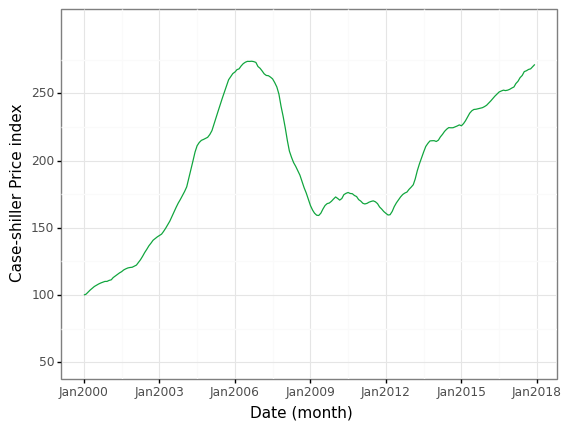

<ggplot: (313148745)>

In [30]:
price_index_plot

In [34]:
#GRAPHS part 2

In [35]:
#Create train/holdout data

In [36]:
data_holdout= data.loc[data['date'].dt.year==2017,:]
data_train= data.loc[data['date'].dt.year<2017,:]

In [37]:
#TODO:
#data seems ok but stat values don't match
#R kpss_stat=1.47
#R doc
#unitroot_kpss computes the statistic for the
#Kwiatkowski et al. unit root test with linear trend and lag 1.

statsmodels.tsa.stattools.kpss(data['p'],regression='ct', nlags=1)

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



(1.2007095633957579,
 0.01,
 1,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [38]:
#TODO:
#data seems ok but stat values don't match
#R kpss_stat=1.70
statsmodels.tsa.stattools.kpss(data['lnp'],regression='ct', nlags=1)

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



(1.3121946546487224,
 0.01,
 1,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [39]:
#create arima models in R

In [40]:
y,X = patsy.dmatrices("p ~ month",data_train)

In [41]:
#TODO:
#Problem auto-arima doesnt seem to fit the same model as in R. ?

In [42]:
arima=pmdarima.arima.auto_arima(y,X,with_intercept=True,seasonal=False)

/usr/local/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 403, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/usr/local/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 364, in _fit_wrapper
    arima = sm.tsa.statespace.SARIMAX(
  File "/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py", line 327, in __init__
  File "/usr/local/lib/python3.8/site-packages/statsmodels/tsa/arima/specification.py"

In [43]:
arima

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [44]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  204
Model:                        SARIMAX   Log Likelihood               -1082.226
Date:                Thu, 15 Apr 2021   AIC                           2190.453
Time:                        13:08:35   BIC                           2233.588
Sample:                             0   HQIC                          2207.902
                                - 204                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        186.1028     11.616     16.021      0.000     163.335     208.870
x1            -0.1113     16.452     -0.007      0.995     -32.356      32.134
x2             0.7552     16.510      0.046      0.964     -31.604      33.114
x3             2.5533     16.504      0.155      0.877     -29.795      34.901
x4             4.6419     16.493      0.281      0.778     -27.684      36.967
x5             6.5694     16.508      0.398      0.691     -25.785      38.924
x6             8.1724     16.530      0.494      0.621     -24.226      40.570
x7             9.2186     16.600      0.555      0.579     -23.316      41.753
x8             9.8414     16.631      0.592      0.554     -22.754      42.437
x9             9.9162     16.668      0.595      0.552     -22.752      42.584
x10            9.6691     16.751      0.577      0.564     -23.163      42.501
x11            9.3232     16.815      0.554      0.579     -23.634      42.281
sigma2      2373.6744    336.725      7.049      0.000    1713.705    3033.643
===================================================================================
Ljung-Box (L1) (Q):                 201.37   Jarque-Bera (JB):                 8.96
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.37   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         1.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
#Setting pdq values as found by R ARIMA the values are pretty close

In [46]:
arima = pmdarima.arima.ARIMA(order=(2,1,1),
                             seasonal_order=(0,0,0,0),with_intercept=True)

In [49]:
res = arima.fit(y,X)

ValueError: A constant trend was included in the model specification, but the `exog` data already contains a column of constants.

In [48]:
res.summary()

NameError: name 'res' is not defined

In [104]:
y,X = patsy.dmatrices("dp ~ month",data_train)
arima=pmdarima.arima.auto_arima(y,X,with_intercept=True,seasonal=False)
arima

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [105]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  203
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -255.447
Date:                Wed, 13 Jan 2021   AIC                            538.895
Time:                        10:28:29   BIC                            585.280
Sample:                             0   HQIC                           557.660
                                - 203                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1818      1.134     -0.160      0.873      -2.405       2.041
x1             0.1833      0.161      1.136      0.256      -0.133       0.500
x2             1.1581      0.247      4.685      0.000       0.674       1.642
x3             2.0872      0.304      6.859      0.000       1.491       2.684
x4             2.3754      0.375      6.341      0.000       1.641       3.110
x5             2.2126      0.399      5.542      0.000       1.430       2.995
x6             1.8868      0.428      4.404      0.000       1.047       2.727
x7             1.3291      0.426      3.121      0.002       0.495       2.164
x8             0.9052      0.401      2.260      0.024       0.120       1.690
x9             0.3573      0.340      1.050      0.294      -0.309       1.024
x10            0.0357      0.277      0.129      0.897      -0.507       0.578
x11           -0.0623      0.201     -0.309      0.757      -0.457       0.332
ar.L1          0.9375      0.020     46.851      0.000       0.898       0.977
sigma2         0.7178      0.064     11.293      0.000       0.593       0.842
===================================================================================
Ljung-Box (Q):                       46.15   Jarque-Bera (JB):                48.21
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.67
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
reg1 = smf.ols('dlnp ~ dlnp_lag', data=data_train).fit()

In [109]:
print(reg1.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:                   dlnp   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     839.7
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           1.63e-73
Time:                        10:33:45   Log-Likelihood:                 779.72
No. Observations:                 202   AIC:                            -1555.
Df Residuals:                     200   BIC:                            -1549.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003      0.000      0.771      0.4

In [110]:
##Fit ARIMA type models